# Logistic Regression

### Loading Training Data

In [7]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import collections
from scipy import linalg
from time import gmtime, strftime, localtime

print(os.listdir("../data/train"))

['images_training.h5', 'labels_training.h5']


In [8]:
with h5py.File('../data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('../data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# Checking dimensions of training data
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


### Feature scaling and Dimension Reduction

In [12]:
# Feature Scaling
def feature_scaling(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1  # divide by 0 adjustment
    return x_min + nom/denom 

# apply function on training data
# data_train_scaled = feature_scaling(data_train, -0.5, 0.5)
# data_train_scaled = (data_train - data_train.mean(0)) / data_train.std(0)
data_train_scaled = data_train / data_train.std(0)

# print(data_train[0])
print(data_train.std(0).shape)
print(data_train.shape)

(784,)
(30000, 784)


In [4]:
# Dimension reduction using SVD
U, A, Vt = linalg.svd(data_train_scaled, full_matrices=False)

# Selecting k dimensions
k=784
print("Feature selection : {}".format(k))

Feature selection : 784


Comparing a sample data. The first example belongs to class 0: T-Shirt/Top
- Figure 1 is reconstructed from SVD with k features.
- Figure 2 is actual image data.

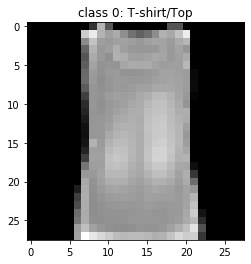

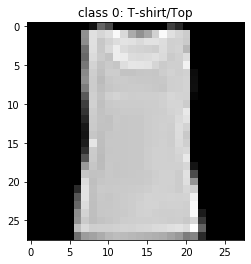

In [5]:
# Reconstructing and visualising truncated data
data_train_reconstuct = np.dot(U[:,0:k], np.dot(np.diag(A[0:k]),Vt[0:k,:]))

data_recon_shaped = data_train_reconstuct.reshape((data_train_reconstuct.shape[0], 28, 28))
data_train_shaped = data_train.reshape((data_train.shape[0], 28, 28))

plt.imshow(data_recon_shaped[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

plt.imshow(data_train_shaped[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

In [6]:
# Truncated SVD based on k features selection
# This truncated data will be used for training and validation
# Overwriting training data with truncated training data
# data_train = np.dot(U[:,0:k], np.diag(A[0:k]))
data_train = data_train_scaled

# Checking dimension
print(data_train.shape)

(30000, 784)


### Logistic Regression and optimisation

In [7]:
# Sigmoid function
def sigmoid_function(x):
    return (1 / (1 + np.exp(-x)))

# Loss/cross entropy function - log likelihood
def cross_entropy_error_e(features_x, label_y, theta_s):
    sigma = sigmoid_function(features_x @ theta_s)
    sigma[sigma == 1] = 0.999999 # avoid 0 for log(1)
    
    entropy_error = label_y.T @ np.log(sigma) + (1 - label_y).T @ np.log(1 - sigma)
    entropy_error = -1 * entropy_error
    return entropy_error / len(label_y)

In [8]:
# Loss/cross entropy function - log likelihood
# Added regularisation paramter "lambda"
def cross_entropy_error_regularized(features_x, label_y, theta_s, lambda_r):
    sigma = sigmoid_function(features_x @ theta_s)
    sigma[sigma == 1] = 0.999999 # avoid 0 for log(1)
    
    entropy_error = label_y.T @ np.log(sigma) + (1 - label_y).T @ np.log(1 - sigma)
    entropy_error = (-1 * entropy_error) + ((lambda_r/2) * theta_s.T @ theta_s)
    return entropy_error / len(label_y)

In [9]:
# Gradient descent for optimisation
def gradient_descent_gd(features_x, label_y, learn_rate, num_iter, lambda_r):
    num_features = features_x.shape[1]
    theta = np.zeros(num_features)
    entropy_error_hist = np.zeros((num_iter,1))
    
    for i in range(num_iter):
        sigma = sigmoid_function(features_x @ theta)
        theta -= (learn_rate * (features_x.T @ (sigma - label_y))) / len(label_y)
        entropy_error_hist[i] = cross_entropy_error_regularized(features_x, label_y, theta_s=theta, lambda_r=lambda_r)
    return entropy_error_hist, theta

In [10]:
#merging labels with features before random folds
data_combined = np.c_[data_train, label_train]

### Training and Validation split

In [11]:
# Creating validation and train data based on random index
indices = np.random.permutation(data_combined.shape[0])
# Traing set - 50%
# Validation set 1 - 10%
# Validation set 2 - 10%
training_idx, validation_idx = indices[:int(0.5*data_combined.shape[0])], indices[int(0.7*data_combined.shape[0]):int(0.8*data_combined.shape[0])]

In [12]:
# adding 1's for constant weight w0
data_combined = np.c_[np.ones(data_combined.shape[0]), data_combined]

In [13]:
training_set, validation_set = data_combined[training_idx,:], data_combined[validation_idx,:]
print(training_set.shape)

(15000, 786)


### Find optimum learning rate and lamda for one label

In [14]:
# from math import ceil

# # find optimum learning rate and lamda for one label
# label_learn = (training_set[:,k+1] == 7).astype(int)
# init_theta = np.zeros(training_set.shape[1] - 1)

# # Initial loss/cost
# entropy_initial = cross_entropy_error_regularized(features_x=training_set[:,0:(k+1)],label_y=label_learn,theta_s=init_theta, lambda_r=2)
# print("Initial cost with theta = 0 for item {} is : {}".format(0, entropy_initial))

# num_iters = 5000
# # sample learning rates
# learning_rates = [0.01, 0.02,0.05, 0.1]
# # sample lambda
# lambda_rate = [2,5]

# print("Starting learning for item : 7")
# plt.figure(figsize=(14,8))
# leg = []

# for lr in learning_rates:
#     print("Learning rate set to : {} ...".format(lr))
#     for lm in lambda_rate:
#         cost_history, temp = gradient_descent_gd(features_x=training_set[:,0:(k+1)], label_y=label_learn, learn_rate=lr, num_iter=num_iters, lambda_r=lm)
#         leg.append(str(lr) + " and " + str(lm))
#         plt.plot(cost_history, linewidth=2)

# plt.title("Convergence plots for different learning rates")
# plt.xlabel("number of iterations", fontsize=14)
# plt.ylabel("cost", fontsize=14)
# plt.legend(list(map(str, leg)))
# plt.axis([0, num_iters, 0, 0.7])
# plt.grid()

In [15]:
# registering time for perfomance measurement
start = time.time()
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

Mon, 21 Oct 2019 19:24:15 +0000


### Model training and find accuracy

In [16]:
%%time
# Training data
X = training_set[:,0:(k+1)]
# Labels for training set
y = training_set[:,k+1]
# Initializing classifier for each label
classifiers = np.zeros(shape=(10, training_set.shape[1] - 1))
print("Classifier size : {}".format(classifiers.shape))

for c in range(0, 10):
    label = (y == c).astype(int)
    _, classifiers[c, :] = gradient_descent_gd(features_x=X, label_y=label, learn_rate=0.015, num_iter=800, lambda_r=10)

# Predicting probabilities
classProbabilities = sigmoid_function(X @ classifiers.transpose())

# labeling data based on maximum probability
predictions = classProbabilities.argmax(axis=1)

# Accuracy measurement for training data
print("-------------------------------------------------------")
print("Training accuracy:", str(100 * np.mean(predictions == y)) + "%")
print("-------------------------------------------------------")
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

Classifier size : (10, 785)
-------------------------------------------------------
Training accuracy: 83.68666666666667%
-------------------------------------------------------
Mon, 21 Oct 2019 19:25:58 +0000
CPU times: user 3min 15s, sys: 2.74 s, total: 3min 18s
Wall time: 1min 43s


In [17]:
# Prediction distribution
print(collections.Counter(predictions))

Counter({4: 1724, 9: 1605, 7: 1600, 3: 1593, 8: 1518, 2: 1511, 0: 1490, 1: 1479, 5: 1344, 6: 1136})


### Validate set 1

In [18]:
%%time
# Applying classifier on validation set 1
X = validation_set[:,0:(k+1)]
y = validation_set[:,(k+1)]

classProbabilities = sigmoid_function(X @ classifiers.transpose())
predictions = classProbabilities.argmax(axis=1)
print("-------------------------------------------------------")
print("validation accuracy:", str(100 * np.mean(predictions == y)) + "%")
print("-------------------------------------------------------")

print("Prediction distribution for Validation set 1 : {}".format(collections.Counter(predictions)))
print("--- Total time taken in Training and Validation ---")
print("--- %s sec ---" % (time.time() - start))
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

-------------------------------------------------------
validation accuracy: 81.76666666666667%
-------------------------------------------------------
Prediction distribution for Validation set 1 : Counter({4: 342, 2: 332, 3: 331, 9: 328, 1: 301, 7: 298, 0: 294, 8: 289, 5: 255, 6: 230})
--- Total time taken in Training and Validation ---
--- 103.09307909011841 sec ---
Mon, 21 Oct 2019 19:25:58 +0000
CPU times: user 13.1 ms, sys: 1.88 ms, total: 15 ms
Wall time: 6.56 ms


### Validate set 2

In [19]:
%%time
# Applying classifier on validation set 2
validation_idx_2 = indices[int(0.8*data_combined.shape[0]):int(0.9*data_combined.shape[0])]
validation_set_2 = data_combined[validation_idx_2,:]

X = validation_set_2[:,0:(k+1)]
y = validation_set_2[:,(k+1)]
classProbabilities = sigmoid_function(X @ classifiers.transpose())
predictions = classProbabilities.argmax(axis=1)
print("-------------------------------------------------------")
print("validation set 2 accuracy:", str(100 * np.mean(predictions == y)) + "%")
print("-------------------------------------------------------")

print("Prediction distribution for Validation set 2 : {}".format(collections.Counter(predictions)))
print(collections.Counter(predictions))
print("--- %s sec ---" % (time.time() - start))
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

-------------------------------------------------------
validation set 2 accuracy: 81.73333333333333%
-------------------------------------------------------
Prediction distribution for Validation set 2 : Counter({4: 353, 3: 352, 9: 328, 8: 324, 7: 320, 2: 311, 1: 292, 0: 268, 5: 246, 6: 206})
Counter({4: 353, 3: 352, 9: 328, 8: 324, 7: 320, 2: 311, 1: 292, 0: 268, 5: 246, 6: 206})
--- 103.11717700958252 sec ---
Mon, 21 Oct 2019 19:25:58 +0000
CPU times: user 26.2 ms, sys: 7.79 ms, total: 34 ms
Wall time: 16.3 ms


### Cross check classifiers against Test Data

In [20]:
%%time

with h5py.File('../data/test/images_testing.h5','r') as H:
    data_pred = np.copy(H['datatest'])
with h5py.File('../data/test/labels_testing_2000.h5','r') as H:
    label_pred = np.copy(H['labeltest'])
               
# Feature scaling for test data
# data_pred_scaled = feature_scaling(data_pred, -0.5, 0.5)
# data_pred_scaled = (data_pred - data_pred.mean(0)) / data_pred.std(0)
data_pred_scaled = data_pred / data_pred.std(0)

# SVD on test data to match classifier dimension
U_test, A_test, Vt_test = linalg.svd(data_pred_scaled, full_matrices=False)
# data_pred = np.dot(U_test[:,0:k], np.diag(A_test[0:k]))
data_pred = data_pred_scaled
print("Test data size : {}".format(data_pred.shape))

# padding 1's
data_pred_combined = np.c_[np.ones(data_pred.shape[0]), data_pred]

# Selecting first 2000 samples with labels
X = data_pred_combined[0:2000,:]
y = label_pred

# Predicting output labels
classProbabilities = sigmoid_function(X @ classifiers.transpose())
# classProbabilities = sigmoid_function(np.dot(X, classifiers.transpose()))
predictions = classProbabilities.argmax(axis=1)
print(predictions.shape, classifiers.shape, classifiers.transpose().shape)

print("-------------------------------------------------------")
print("Testing accuracy:", str(100 * np.mean(predictions == y)) + "%")
print("-------------------------------------------------------")
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

Test data size : (10000, 784)
(2000,) (10, 785) (785, 10)
-------------------------------------------------------
Testing accuracy: 82.15%
-------------------------------------------------------
Mon, 21 Oct 2019 19:25:59 +0000
CPU times: user 1.16 s, sys: 112 ms, total: 1.27 s
Wall time: 685 ms
